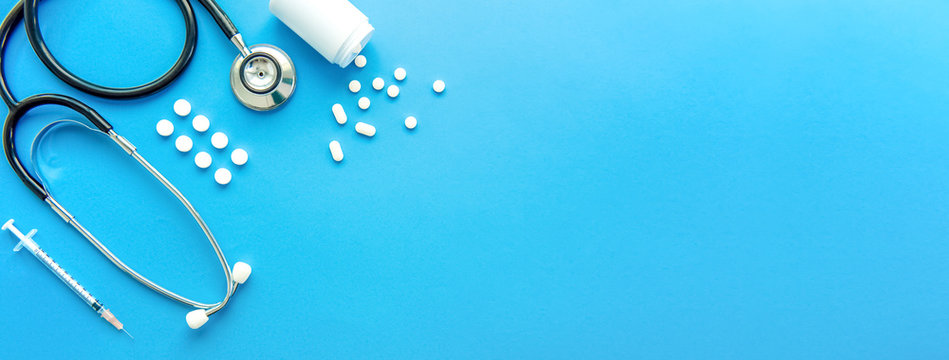

# Stroke Diagnostic Modeling

**Authors:** Anita Camlic, Eddie Juarez, Dermot O'Brien
***

## Overview

According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

## Business Problem

Hospitals are constantly looking for new ways to detect health risks in their patients before they occur. We have been asked by Mount Sinai to create a model that can predict the likelihood of a stroke in their patients with the use of patient data. The model will flag patients who are at risk of a stroke and will give their general practitionars the opporutnity to work with them on health plans to prevent them from occuring. The model will act as a preliminary diagnosic tool available for all doctors, allowing them to better serve their patients. We will also highlgiht the features of the model that contribute the the most to the models predictions

## Data Overview

### Data Dictionary

- `id`: unique identifier
- `gender`: "Male", "Female" or "Other"
- `sex`: Sex
- `age`: age of the patient
- `hypertension`: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
- `heart_disease`: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
- `ever_married`: "No" or "Yes"
- `work_type`: children", "Govt_job", "Never_worked", "Private" or "Self-employed"
- ` Residence_type`: "Rural" or "Urban"
- `avg_glucose_level`: average glucose level in blood
- `bmi`: body mass index
- `smoking_status`: "formerly smoked", "never smoked", "smokes" or "Unknown"
- `stroke`: 1 if the patient had a stroke or 0 if not

**Note:** "Unknown" in smoking_status means that the information is unavailable for this patient

## Data Understanding

In this section, we are going to explore the dataset with summary statistics and then take a deeper dive into the variables with some visualizations. We are expecting to find some missing values and mislabeled data that we can clean later on.

### Import Data and Create Dataframes

In [1]:
# Import Standard Packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score as rere, accuracy_score, precision_score, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import MissingIndicator
from sklearn.impute import KNNImputer
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
%matplotlib inline

In [2]:
# Import the data
df = pd.read_csv('./Data/stroke.csv')

### Exploratory Data Analysis (EDA)

In [3]:
# Check rows and columns
df.shape

(5110, 12)

In [4]:
# See what each row looks like
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
# Check descriptive statistics of numeric columns
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [6]:
# Check BMI data
df.bmi.sort_values(ascending=False).head(30)

2128    97.6
4209    92.0
928     78.0
544     71.9
1559    66.8
358     64.8
4188    64.4
2764    63.3
3825    61.6
2840    61.2
270     60.9
4838    60.9
466     60.2
3588    59.7
3060    58.1
4351    57.9
1898    57.7
715     57.5
1595    57.3
4475    57.2
4154    57.2
113     56.6
4952    56.6
2081    56.1
1660    56.0
1584    55.9
4225    55.9
4407    55.7
672     55.7
662     55.7
Name: bmi, dtype: float64

The NIH BMI table max's out at 54, so we are probably going to drop values above that.

In [7]:
# Check for NaN's
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Will need to drop or impute these null values, will probably use knn imputer.

In [8]:
# Check the value counts of the stroke column
df.stroke.value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [9]:
# Check the percentage distribution of the stroke column
df.stroke.value_counts(normalize=True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

Very imbalanced class data. We will need to use class_weight() parameters and/or SMOTE to address this.

In [10]:
# Check gender value counts
df.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

Likely drop `Other` column from gender do to insufficient data

In [12]:
# Check the stroke rates of males and females
df[['gender', 'stroke']].groupby('gender', as_index=False).mean().sort_values(by='stroke', ascending=False)

,gender,stroke
1,Male,0.051064
0,Female,0.047094
2,Other,0.000000


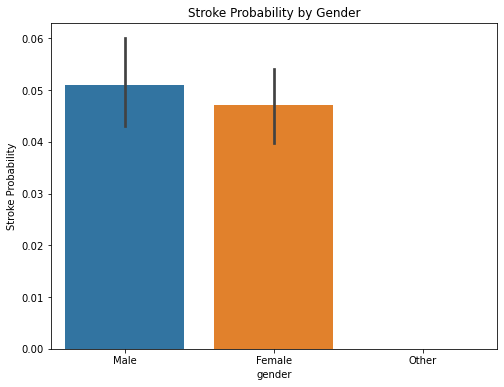

In [13]:
# Create a barplot showing the Stroke Probabilities of males and females
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x='gender', y='stroke', data=df)
ax.set_ylabel('Stroke Probability')
ax.set_title('Stroke Probability by Gender');

In [15]:
# Check age for stroke victims
df.loc[df['stroke'] == True]['age'].sort_values()

162     1.32
245    14.00
182    32.00
118    38.00
133    38.00
       ...  
42     82.00
56     82.00
188    82.00
23     82.00
35     82.00
Name: age, Length: 249, dtype: float64

In [17]:
# Check BMI
df.loc[df['bmi'].isnull()]['stroke'].value_counts(normalize=True) 

0    0.800995
1    0.199005
Name: stroke, dtype: float64

This tells us that its important to keep the null values since it somehow contributes to people having a stroke or not.

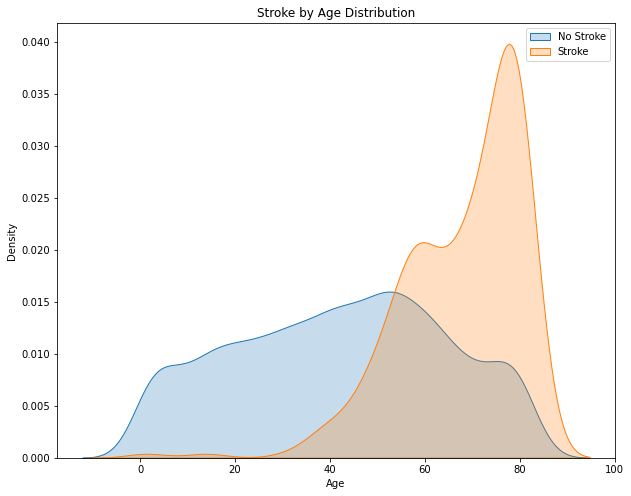

In [23]:
# Create a KDE Plot that shows the Stroke rate of patiens by Age distribution
sns.kdeplot(df['age'][df['stroke'] == 0], label='No Stroke', fill=True)
sns.kdeplot(df['age'][df['stroke'] == 1], label='Stroke', fill=True)
plt.rcParams["figure.figsize"] = (10,8)
plt.xlabel('Age')
plt.title('Stroke by Age Distribution')
plt.legend();

In [29]:
df.work_type.value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

Children isnt a `work_type`, so we will probably change children values with Never_worked

In [32]:
df.loc[((df['smoking_status'] == 'Unknown') & (df['age'] <= 12))]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
162,69768,Female,1.32,0,0,No,children,Urban,70.37,NaN,Unknown,1
249,30669,Male,3.00,0,0,No,children,Rural,95.12,18.0,Unknown,0
251,16523,Female,8.00,0,0,No,Private,Urban,110.89,17.6,Unknown,0
282,33759,Female,3.00,0,0,No,children,Urban,73.74,16.0,Unknown,0
291,11014,Male,4.00,0,0,No,children,Rural,79.17,20.0,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5078,27446,Female,8.00,0,0,No,children,Urban,76.31,15.5,Unknown,0
5079,42709,Male,1.72,0,0,No,children,Urban,77.28,17.1,Unknown,0
5089,56714,Female,0.72,0,0,No,children,Rural,62.13,16.8,Unknown,0
5095,68598,Male,1.08,0,0,No,children,Rural,79.15,17.4,Unknown,0


We can assume that children <=12 do not smoke, so we can change their Unknown status to never worked

## Data Preparation

Based on our EDA, we are going to make some changes to the dataset in hopes to return more accurate metrics from our models. See preparations below:

In [34]:
# Drop row with gender = 'other'
df = df[df.gender != 'Other']

In [35]:
# Drop ID column
df.drop(labels='id', axis=1, inplace=True)

In [36]:
# Put all children work type into never worked
df['work_type'] = df['work_type'].replace(['children'], 'Never_worked')

In [37]:
# If observation is under teenage age (12) and smoking status unknown, change smoking status to never smoked
df.loc[((df['smoking_status'] == 'Unknown') & (df['age'] <= 12)),'smoking_status'] = 'never smoked'

In [38]:
# Drop all observations with bmi greater than 54 because the NIH table limit is 54
df = df.loc[((df['bmi'] <= 54) | (df['bmi'].isna()))]

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

### Class Setup for Model Evaluation

In [ ]:
# Create a Class to evaluate each model with cross validation

class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_accuracy = None
        self.cv_precision = None
        self.cv_recall = None

        # wut
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=5):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_accuracy = cross_val_score(self.model, cv_X, cv_y, cv=kfolds).mean()
        self.cv_recall = cross_val_score(self.model, cv_X, cv_y, cv=kfolds, scoring='recall').mean()
        self.cv_precision = cross_val_score(self.model, cv_X, cv_y, cv=kfolds, scoring='precision').mean()

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_accuracy: .5f} accuracy
            {self.cv_recall: .5f} recall
            {self.cv_precision: .5f} precision
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

### Dummy Model

In [ ]:
# Create variables and split data into training and testing
X = df.drop('stroke', axis=1)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
# Dummy Model
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(X_train, y_train)

In [ ]:
# Plot a confusion matrix for our dummy model
plot_confusion_matrix(dummy_model, X_train, y_train);

In [ ]:
# Evaluate model with CV
dummy_results = ModelWithCV(model=dummy_model,
                         model_name='dummy_results',
                         X=X_train,
                         y=y_train)

dummy_results.print_cv_summary()

### Pipeline Setup

In [ ]:
# Create pipelines for missing indicator, numeric and categorical to fit into Categorical Transformer.
knn_imp_pipeline = Pipeline(steps=[('knn_imp', KNNImputer(add_indicator=True))])
num_pipeline = Pipeline(steps=[ ('ss', StandardScaler())])
cat_pipeline = Pipeline(steps=[('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

In [ ]:
# The "remainder='passthrough'" bit tells the compiler to leave the other df columns unchanged.
CT = ColumnTransformer(transformers=[('num_pipeline', num_pipeline, ['age', 'avg_glucose_level', 'bmi']),
                                         ('cat_pipeline', cat_pipeline, ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])],
                           remainder='passthrough')

### Logistic Regression

In [ ]:
# Create a logistic regression model using created pipeline
logreg_pipe = Pipeline(steps=[('ct', CT),
                              ('knn_imp',knn_imp_pipeline),
                            ('logreg', LogisticRegression())])
logreg_pipe.fit(X_train, y_train)

In [ ]:
# Plot a confusion matrix for our Log reg model
plot_confusion_matrix(logreg_pipe, X_train, y_train);

In [ ]:
# Evaluate model with CV
logreg_results = ModelWithCV(model=logreg_pipe,
                         model_name='logreg_pipe',
                         X=X_train,
                         y=y_train)

logreg_results.print_cv_summary()

### Decision Trees

In [ ]:
# Create a decision tree model using created pipeline
dtree_pipe = Pipeline(steps=[('ct', CT),
                             ('knn_imp',knn_imp_pipeline),
                            ('decisiontree', DecisionTreeClassifier())])
dtree_pipe.fit(X_train, y_train)

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(dtree_pipe, X_train, y_train);

In [ ]:
# Evaluate model with CV
dtree_results = ModelWithCV(model=dtree_pipe,
                         model_name='dtree_pipe',
                         X=X_train,
                         y=y_train)

dtree_results.print_cv_summary()

**above is incorrect**

### KNN

In [ ]:
# Create a knn model using created pipeline
knn_pipe = Pipeline(steps=[('ct', CT),
                           ('knn_imp',knn_imp_pipeline),
                            ('knn', KNeighborsClassifier())])
knn_pipe.fit(X_train, y_train)

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(knn_pipe, X_test, y_test);

In [ ]:
# Evaluate model with CV
knn_results = ModelWithCV(model=knn_pipe,
                         model_name='knn_pipe',
                         X=X_train,
                         y=y_train)

knn_results.print_cv_summary()

### Random Forest

In [ ]:
# Create a knn model using created pipeline
rfc_pipe = Pipeline(steps=[('ct', CT),
                           ('knn_imp',knn_imp_pipeline),
                            ('rfc', RandomForestClassifier())])
rfc_pipe.fit(X_train, y_train)

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(rfc_pipe, X_test, y_test);

In [ ]:
# Evaluate model with CV
rfc_results = ModelWithCV(model=rfc_pipe,
                         model_name='rfc_pipe',
                         X=X_train,
                         y=y_train)

rfc_results.print_cv_summary()

It looks as though the models with the highest accuracy are logistic regression(0.95197 accuracy) and Random Forests(0.95197 accuracy). However, the model with the highest recall is Decision Trees( 0.16111 recall).

### Gradient Boost

In [ ]:
gb_pipe = Pipeline(steps=[('ct', CT),
                          ('knn_imp',knn_imp_pipeline),
                            ('gb', GradientBoostingClassifier())])
gb_pipe.fit(X_train, y_train)

In [ ]:
# Evaluate model with CV
gb_results = ModelWithCV(model=gb_pipe,
                         model_name='gb_pipe',
                         X=X_train,
                         y=y_train)

gb_results.print_cv_summary()

## Grid Search

In [ ]:
# Random Forest Grid Search 
rf_grid = {'rfc__max_depth': [3,5,7],
 'rfc__max_features': ['auto', 'sqrt',None],
 'rfc__min_samples_leaf': [1, 2, 3],
 'rfc__min_samples_split': [2, 5, 10],
 'rfc__n_estimators': [10,100,200,500]}


In [ ]:
rf_gs = GridSearchCV(estimator=rfc_pipe, param_grid=rf_grid, cv=5, scoring='recall')

In [ ]:
rf_gs.fit(X_train,y_train)

In [ ]:
rf_gs.best_params_

In [ ]:
rf_gs.best_score_

In [ ]:
rf_grid1 = {'rfc__max_depth': [7,9,11],
 'rfc__max_features': ['sqrt'],
 'rfc__min_samples_leaf': [1],
 'rfc__min_samples_split': [2],
 'rfc__n_estimators': [5,7,10]}

rf_gs1 = GridSearchCV(estimator=rfc_pipe, param_grid=rf_grid1, cv=5, scoring='recall',verbose=3)

In [ ]:
rf_gs1.fit(X_train,y_train)

In [ ]:
rf_gs1.best_params_

In [ ]:
rf_gs1.best_score_

In [ ]:
rf_grid2 = {'rfc__max_depth': [11,13,15,17],
 'rfc__max_features': ['sqrt'],
 'rfc__min_samples_leaf': [1,2,3],
 'rfc__min_samples_split': [2,5,10],
 'rfc__n_estimators': [50,100,150,200],
 'rfc__class_weight': ['balanced','balanced_subsample']}

rf_gs2 = GridSearchCV(estimator=rfc_pipe, param_grid=rf_grid2, cv=5, scoring='recall',verbose=3)

In [ ]:
rf_gs2.fit(X_train,y_train)

In [ ]:
rf_gs2.best_params_

In [ ]:
rf_gs2.best_score_

### SMOTE

In [ ]:
imb_pipe = ImPipeline(steps=[('ct', CT),
                             ('knn_imp', KNNImputer(add_indicator=True)),
                             ('sm', SMOTE()),
                            ('rfc', RandomForestClassifier())])

In [ ]:
imb_pipe.fit(X_train,y_train)

In [ ]:
imb_results = ModelWithCV(model=imb_pipe,
                         model_name='imb_pipe',
                         X=X_train,
                         y=y_train)

imb_results.print_cv_summary()

In [ ]:
imb_grid = {'rfc__max_depth': [11,13,15,17],
 'rfc__max_features': ['sqrt'],
 'rfc__min_samples_leaf': [1,2,3],
 'rfc__min_samples_split': [2,5,10],
 'rfc__n_estimators': [50,100,150,200],
 'rfc__class_weight': ['balanced','balanced_subsample'],
 'sm__k_neighbors': [3, 5, 9]}

imb_gs = GridSearchCV(estimator=imb_pipe, param_grid=imb_grid, cv=5, scoring='recall',verbose=3,n_jobs=-2)

In [ ]:
imb_gs.fit(X_train,y_train)

In [ ]:
imb_gs.best_params_

In [ ]:
imb_gs.best_score_

#### XGBoost

##### Round 1

In [ ]:
xgb_pipe = ImPipeline(steps=[('ct', CT),
                             ('knn_imp', KNNImputer(add_indicator=True)),
                             ('sm', SMOTE()),
                            ('xgb', xgb.XGBClassifier(objective='binary:logistic', missing=None))])

In [ ]:
xgb_param_grid_1 = {'sm__k_neighbors': [3, 5, 9],
                  'sm__sampling_strategy': ['auto', .7, .8, .9],
                  'xgb__max_depth' : [3,4,5],
                  'xgb__learning_rate': [.1,.01,.05],
                  'xgb__gamma' : [0,.25,1], #encourages pruning
                  'xgb__reg_lambda': [0,1,10], #regularization param
                  'xgb__scale_pos_weight': [1,3,5]} #penalty on choosing incorrect class

In [ ]:
xgb_gs_1 = GridSearchCV(estimator=xgb_pipe, 
                      param_grid=xgb_param_grid_1, 
                      cv=5,
                      scoring='recall',
                      verbose=3,
                      n_jobs=-2)

In [ ]:
xgb_gs_1.fit(X_train,y_train)

In [ ]:
xgb_gs_1.best_params_

In [ ]:
xgb_gs_1.best_score_

In [ ]:
best_xgb_1 = xgb_gs_1.best_estimator_

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(best_xgb_1, X_train, y_train, values_format='d', display_labels=['Stroke','No Stroke']);

In [ ]:
# Evaluate model with CV
best_xgb_results_1 = ModelWithCV(model=best_xgb,
                         model_name='best_xgb',
                         X=X_train,
                         y=y_train)

In [ ]:
best_xgb_results.print_cv_summary()

##### Round 2

In [ ]:
xgb_param_grid_2 = {'sm__k_neighbors': [9, 11, 13],
                    'sm__sampling_strategy': [.8],
                    'xgb__max_depth' : [1, 2, 3],
                    'xgb__learning_rate': [.01],
                    'xgb__gamma' : [.25], #encourages pruning
                    'xgb__reg_lambda': [10, 15, 20], #regularization param
                    'xgb__scale_pos_weight': [5, 7, 9]} #penalty on choosing incorrect class

In [ ]:
xgb_gs_2 = GridSearchCV(estimator=xgb_pipe, 
                      param_grid=xgb_param_grid_2, 
                      cv=5,
                      scoring='recall',
                      verbose=3,
                      n_jobs=-2)

In [ ]:
xgb_gs_2.fit(X_train,y_train)

In [ ]:
xgb_gs_2.best_params_

In [ ]:
xgb_gs_2.best_score_

In [ ]:
best_xgb_2 = xgb_gs_2.best_estimator_

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(best_xgb_2, X_train, y_train, values_format='d', display_labels=['Stroke','No Stroke']);

In [ ]:
# Evaluate model with CV
best_xgb_results_2 = ModelWithCV(model=best_xgb_2,
                         model_name='best_xgb_2',
                         X=X_train,
                         y=y_train)

In [ ]:
best_xgb_results_2.print_cv_summary()

##### Round 3

In [ ]:
xgb_param_grid_3 = {'sm__k_neighbors': [9],
                    'sm__sampling_strategy': [.8],
                    'xgb__max_depth' : [1],
                    'xgb__learning_rate': [.01],
                    'xgb__gamma' : [.25], #encourages pruning
                    'xgb__reg_lambda': [10], #regularization param
                    'xgb__scale_pos_weight': [7],
                    'xgb__n_estimators': [100, 200, 300],
                    'xgb__colsample_bytree': [.3, .5, .7]} #penalty on choosing incorrect class

In [ ]:
xgb_gs_3 = GridSearchCV(estimator=xgb_pipe, 
                      param_grid=xgb_param_grid_3, 
                      cv=5,
                      scoring='recall',
                      verbose=3,
                      n_jobs=-2)

In [ ]:
xgb_gs_3.fit(X_train, y_train)

In [ ]:
xgb_gs_3.best_params_

In [ ]:
xgb_gs_3.best_score_

In [ ]:
best_xgb_3 = xgb_gs_3.best_estimator_

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(best_xgb_3, X_train, y_train, values_format='d', display_labels=['No Stroke','Stroke']);

In [ ]:
# Evaluate model with CV
best_xgb_results_3 = ModelWithCV(model=best_xgb_3,
                         model_name='best_xgb_3',
                         X=X_train,
                         y=y_train)

In [ ]:
best_xgb_results_3.print_cv_summary()

#### Feature Importance

In [ ]:
from xgboost import plot_importance

In [ ]:
plot_importance(best_xgb_3.steps[3][1], max_num_features=10, importance_type='gain') # weight - # appearances in tree

In [ ]:
trial = CT.fit_transform(X_train)
trial

In [ ]:
knn_imp_pipeline.fit_transform(trial)

In [ ]:
feature_names = ['age', 'avg_glucose_level', 'bmi']

In [ ]:
ohe_features = list(CT.named_transformers_['cat_pipeline']['ohe'].get_feature_names())

In [ ]:
full_features = feature_names + ohe_features

In [ ]:
full_features.extend(['hypertension', 'heart_disease', 'bmi_flag'])
full_features

In [ ]:
full_feature_scores = list(best_xgb_3.steps[3][1].feature_importances_)

In [ ]:
len(full_features)

In [ ]:
len(best_xgb_3.steps[3][1].feature_importances_)

In [ ]:
best_xgb_3.steps[3][1].feature_importances_

In [ ]:
tuples_list = list(zip(full_features, full_feature_scores))

In [ ]:
important_features = pd.DataFrame(tuples_list, columns = ['Features', 'Importance'])
important_features_sorted = important_features.sort_values(by='Importance', ascending=False).head(10)

In [ ]:
important_features_sorted

#### Run Final Model on Test Data

In [ ]:
final_model = best_xgb_3

In [ ]:
y_pred_test = final_model.predict(X_test)

In [ ]:
rere(y_test, y_pred_test)

In [ ]:
plot_confusion_matrix(final_model, X_test, y_test)

#### Visuals

In [ ]:
# Rename columns in feature dataframe for visuals
important_features_sorted['Features'] = important_features_sorted['Features'].replace(['x1_Yes'], 'married')
important_features_sorted['Features'] = important_features_sorted['Features'].replace(['x1_No'], 'not married')
important_features_sorted['Features'] = important_features_sorted['Features'].replace(['x2_Never_worked'], 'never worked')
important_features_sorted['Features'] = important_features_sorted['Features'].replace(['bmi_flag'], 'bmi flag')
important_features_sorted['Features'] = important_features_sorted['Features'].replace(['avg_glucose_level'], 'avg glucose level')
important_features_sorted['Features'] = important_features_sorted['Features'].replace(['heart_disease'], 'heart disease')
important_features_sorted['Features'] = important_features_sorted['Features'].replace(['x2_Self-employed'], 'self-employed')

In [ ]:
# Visualize Feature Importance

# Create variables for chart
important_features_x = important_features_sorted['Features']
feature_scores_y = important_features_sorted['Importance']
y_ticks = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40]
c = ['#34b456', '#747474', '#747474', '#747474', '#34b456', '#747474', '#747474', '#747474', '#747474', '#747474']

# Change font family
plt.rcParams.update({'font.family':'Gill Sans'})

# Create bar chart
fig, ax = plt.subplots(figsize = (20,10))

bars = ax.bar(important_features_x, feature_scores_y, color=c)
ax.set_xlabel('Features', fontsize=27, labelpad=20) 
ax.set_ylabel('Importance Scores', fontsize=27, labelpad=25)
ax.set_title('Feature Importance to Model Predictions', fontsize=30, pad=15)
ax.set_ylim(0, 0.40, 0.05)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks, fontsize=20)
ax.set_xticks(important_features_x)
ax.set_xticklabels(important_features_x, fontsize=20, rotation=45);

plt.savefig('./Results/Feature_Importances.jpg', bbox_inches='tight')

In [ ]:
# Create a KDE Plot that shows the distribution of stroke vs not strok by Age
sns.kdeplot(df['age'][df['stroke'] == 1], label='Stroke', color='#34b456', fill=True)
sns.kdeplot(df['age'][df['stroke'] == 0], label='No Stroke', color='#ff1616', fill=True)
plt.rcParams.update({'font.family':'Gill Sans'})
plt.rcParams["figure.figsize"] = (15, 15)
plt.xlabel('Age', fontsize=27, labelpad=20)
plt.ylabel('Density', fontsize=27, labelpad=25)
plt.title('Age Distribution of Stroke vs No Stroke', fontsize=30, pad=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc="upper left", fontsize=20)

plt.savefig('./Results/Age_Distribution.jpg', bbox_inches='tight');

In [ ]:
# Create a Scatter Plot showing the Age and BMI's of Stroke Victims
bmi_X = df['age']
bmi_y = df['bmi']
stroke_z = df['stroke']
#ax = 
sns.scatterplot(data=df, x=bmi_X, y=bmi_y, hue=stroke_z, style=stroke_z, palette=['#ff1616','#34b456'], size=stroke_z, sizes={0:5, 1:100})
#sns.scatterplot(ax=ax);
plt.rcParams.update({'font.family':'Gill Sans'})
plt.rcParams["figure.figsize"] = (15, 10)
plt.xlabel('Age', fontsize=27, labelpad=20)
plt.ylabel('BMI', fontsize=27, labelpad=25)
plt.title('Age vs BMI of Stroke Patients', fontsize=30, pad=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc="upper right", fontsize=15);

plt.savefig('./Results/BMI_Stroke.jpg', bbox_inches='tight');

## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***